In [25]:
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.linalg.lapack import zggev
from sklearn.kernel_ridge import KernelRidge
import seaborn as sns
from kernel_ridge_cv import KernelRidgeCV
from sklearn.model_selection import train_test_split
from scipy.linalg import block_diag
import pandas as pd
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.preprocessing import StandardScaler
from direct_effect_analysis import *
from sklearn.ensemble import RandomForestRegressor
from utils import *
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_ribbon, scale_x_log10, labs, theme, facet_wrap

In [3]:
noises = ['low_rank', 'full_rank', 'diag', 'block_diag']
algorithms = ['PCA', 'CCA', 'GEV', 'EVD']
weights = [(0.2, 0.2, 0.6), (0.6, 0.2, 0.2), (0.2, 0.6, 0.2), (1/3, 1/3, 1/3)]
weights_names = ['strong_N_Y', 'strong_X', 'strong_N_Z', 'equal']
results = {noise:{algo:{weights_name: {} for weights_name in weights_names } for algo in algorithms} for noise in noises}

In [12]:
p, r, d, q, rho, rk = 2, 1, 10, 1, 1, 10
N = 2000

dimensions = [2, 5, 10, 20, 30, 50]

In [5]:
B = 2
for noise in tqdm(noises):
    for algo in algorithms:
        for i, weight in enumerate(weights):
            ap, bp, cp = weight
            # print(noise, algo)
            CORRS = []
            for d in dimensions:
                d = int(d)
                CORR = []
                for b in range(B):
                    A_x, A_z, beta, gamma = parameters(r, p, q, d, True)
                    X_train, X_test, Y_train, Y_test, Z_train, Z_test, Y_x_train, Y_x_test = generate_nonlinear_data(N, p, r, d, beta, gamma, A_x, A_z, noise_type=noise, rk=rk, bs=rk, a=ap, b=bp, c=cp, nl_param=2)
                    dea = DirectEffectAnalysis(type=algo, regressor_0=LinearRegression(), regressor_1=LinearRegression())
                    dea.fit(X_train, Y_train, Z_train)
                    Y_hat = dea.transform(X_train, Y_train, Z_train)
                    corr = np.abs(np.corrcoef(Y_hat, Y_x_train[:,0])[0, 1])

                    
                    # Compute MSE for each iteration
                    CORR.append(corr)
                CORRS.append(CORR)
            # Append MSE for current sample size
            results[noise][algo][weights_names[i]] = CORRS



  0%|          | 0/4 [00:00<?, ?it/s]

/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/homer/Documents/Projects/Anchor_Regression_Detection/.conda/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was

/tmp/ipykernel_915/2885464469.py:37: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


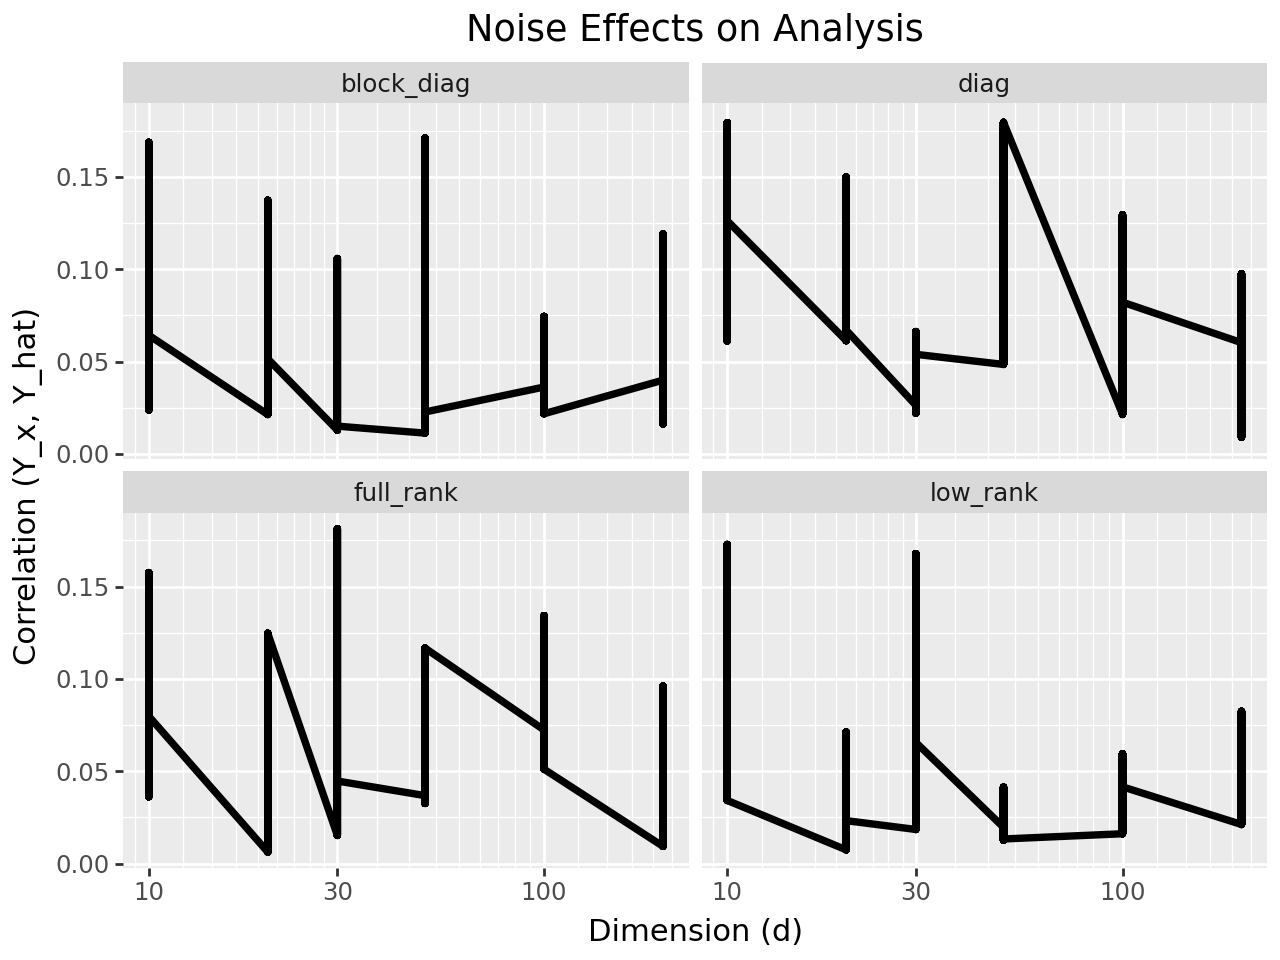

In [67]:

# Prepare data for ggplot
data = []
weight_name = 'strong_X'  # Specify the weight name

for noise in results.keys():
    for analysis_type, weight_data in results[noise].items():
        for key, values in weight_data.items():
            # Extract median and percentiles
            values = np.array(results[noise][algo][key])
            median = np.percentile(values, 50, axis=1)
            lower = np.percentile(values, 25, axis=1)
            upper = np.percentile(values, 75, axis=1)
            
            for i in range(len(dimensions)):
                data.append({
                    'Dimension': dimensions[i],
                    'Median': median[i],
                    'Lower': lower[i],
                    'Upper': upper[i],
                    'Analysis': analysis_type,
                    'Noise': noise
                })

# Create a DataFrame
df = pd.DataFrame(data)

# Plot using ggplot
p = (ggplot(df, aes(x='Dimension', y='Median'))
     + geom_line(size=1.5)
     + scale_x_log10()
     + labs(x='Dimension (d)', y='Correlation (Y_x, Y_hat)', title='Noise Effects on Analysis')
     + facet_wrap('~Noise', ncol=2)  # Create facets for each type of noise
     + theme(legend_position='right')
)

# Display the plot
print(p)

In [66]:
df

,Dimension,Median,Lower,Upper,Analysis,Noise
0,10,0.036530,0.027485,0.045575,PCA,low_rank
1,20,0.007471,0.006589,0.008353,PCA,low_rank
2,30,0.018503,0.013966,0.023041,PCA,low_rank
3,50,0.019656,0.015614,0.023698,PCA,low_rank
4,100,0.016179,0.011626,0.020733,PCA,low_rank
...,...,...,...,...,...,...
379,20,0.051516,0.033565,0.069468,EVD,block_diag
380,30,0.015043,0.013907,0.016179,EVD,block_diag
381,50,0.022711,0.022411,0.023012,EVD,block_diag
382,100,0.021766,0.014339,0.029193,EVD,block_diag


In [39]:
lower.shape, np.array(dimensions).shape

((6,), (6,))

In [56]:
data = []
for noise in noises:
    for algo in algorithms:
        lower = np.percentile(results[noise][algo]['strong_X'], 50, axis=1)
        median = np.percentile(results[noise][algo]['strong_X'], 95, axis=1)
        upper = np.percentile(results[noise][algo]['strong_X'], 5, axis=1)
        for i in range(len(dimensions)):
            data.append({
                'Dimension': dimensions[i],
                'Median': median[i],
                'Lower': lower[i],
                'Upper': upper[i],
                'Algo': algo
            })
df = pd.DataFrame(data)
df

,Dimension,Median,Lower,Upper,Algo
0,10,0.220431,0.167152,0.113874,PCA
1,20,0.271617,0.199596,0.127574,PCA
2,30,0.092200,0.081654,0.071109,PCA
3,50,0.206484,0.155404,0.104325,PCA
4,100,0.119112,0.112555,0.105998,PCA
...,...,...,...,...,...
91,20,0.038238,0.034428,0.030619,EVD
92,30,0.155307,0.105759,0.056211,EVD
93,50,0.047305,0.025797,0.004290,EVD
94,100,0.103447,0.067285,0.031122,EVD


In [57]:
df = pd.DataFrame(data)

# Plot using ggplot
p = (ggplot(df, aes(x='Dimension', y='Median', color='Analysis', fill='Analysis'))
     + geom_line(size=1.5)
     + geom_ribbon(aes(ymin='Lower', ymax='Upper'), alpha=0.2)
     + scale_x_log10()
     + labs(x='Dimension (d)', y='Correlation (Y_x, Y_hat)', title='Noise Effects on Analysis')
     + facet_wrap('~Noise', ncol=2)  # Create facets for each type of noise
     + theme(legend_position='right')
)

# Display the plot
print(p)

plt.plot()

/tmp/ipykernel_915/3701408526.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


PlotnineError: 'At least one layer must contain all variables used for facetting'